# Project 2: DROP OUT CLASSIFIER
(by: Martin Marsal, Benedikt Allmendinger, Christian Diegmann; Heilbronn University, Germany, November 2024)

This project implements and evaluates four different models to classify how likely it is for a student to drop out.

The following references were used:

Your provided PDF (Early Prediction of student's Performance in Higher Education: A Case Study)

https://chatgpt.com/ (ChatGPT)

https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.GaussianNB.html (GaussianNB Documentation)

https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html (DecisionTreeClassifier Documentation)

https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html (KNeighborsClassifier Documentation)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html (RandomForestClassifier Documentation)



# Preprocessing Data

- Nullcheck
- Truncate floating point numbers to second decimal place
- Map target values to level of risk
- Add scaling for certain models

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [19]:
# Convert csv file to a pandas DataFrame
df = pd.read_csv('student_data.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

foundNull = df.isnull().values.any()

if foundNull:
    raise TypeError('Found null value in DataFrame.')

# Rounding to two decimal places
df['Curricular units 2nd sem (grade)'] = df['Curricular units 2nd sem (grade)'].round(2)

# Mapping the target values to level of risk:
df['Target'] = df['Target'].map({'Dropout': 2, 'Enrolled': 1, 'Graduate': 0})

# Create array with feature names for feature relevancy later
feature_names = df.columns

# Print the DataFrame
print(df)

      Marital status  Application mode  Application order  Course  \
0                  1                17                  5     171   
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
3995               1                 1                  6    9773   
3996               1                 1                  2    9773   
3997               1                 1                  1    9500   
3998               1                 1                  1    9147   
3999               1                10                  1    9773   

      Daytime/evening attendance  Previous qualification  \
0                              1                       1   
1                              1                   

# Visualise how the features correlate with each other
Calculate and visualise how the features correlate with each other and with the labels. Pick an interesting correlation
and discuss it.

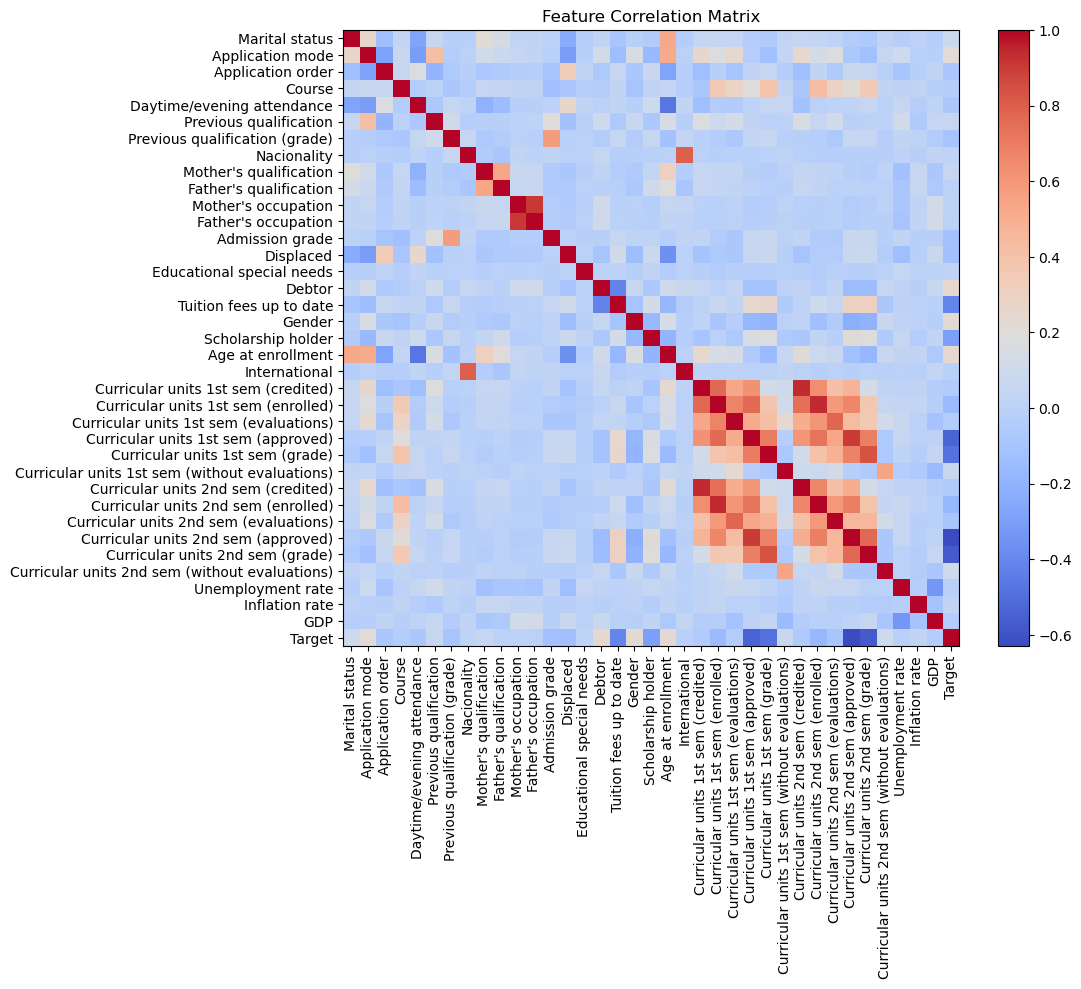

Top 10 Correlations
Marital status                          Marital status                            1.000000
Curricular units 2nd sem (credited)     Curricular units 1st sem (credited)       0.941665
Curricular units 1st sem (enrolled)     Curricular units 2nd sem (enrolled)       0.941261
Mother's occupation                     Father's occupation                       0.907595
Curricular units 1st sem (approved)     Curricular units 2nd sem (approved)       0.902093
Curricular units 1st sem (grade)        Curricular units 2nd sem (grade)          0.837039
Nacionality                             International                             0.790132
Curricular units 1st sem (evaluations)  Curricular units 2nd sem (evaluations)    0.772342
Curricular units 1st sem (credited)     Curricular units 1st sem (enrolled)       0.766862
Curricular units 2nd sem (approved)     Curricular units 2nd sem (grade)          0.765916
dtype: float64


In [20]:
correlation_matrix = df.corr()

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Use imshow to display the correlation matrix
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')

# Add colorbar
plt.colorbar()

# Add labels for rows and columns
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)

# Add title
plt.title('Feature Correlation Matrix')

# Show plot
plt.show()

# Flatten the matrix to sort and identify the highest correlations
correlation_pairs = correlation_matrix.unstack()
sorted_pairs = correlation_pairs.sort_values(key=abs, ascending=False)

# Display top 10 correlations (excluding self-correlation at 1.0)
print("Top 10 Correlations")
print(sorted_pairs.drop_duplicates().head(10))

## Discussion

Curricular units (credited, enrolled, approved) from the first and second semesters tend to have a strong correlation. This is logical, as an individual's performance and workload are generally consistent across semesters.  

Similarly, the occupations of the mother and father show a notable correlation.  

There is also a strong correlation between nationality and being classified as "international." This can be explained by the fact that international students typically have a different nationality than non-international students, while non-international students are usually of the same nationality.


In [21]:
from sklearn.preprocessing import StandardScaler

# Shuffle the DataFrame and reset the index
shuffle_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the size of the training set (80% of the data)
train_size = int(0.8 * len(shuffle_df))

# Split the DataFrame into training and test sets
train_df = shuffle_df.iloc[:train_size]
test_df = shuffle_df.iloc[train_size:]

# Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

# Combine training and test sets for consistent encoding
combined_df = pd.concat([train_df, test_df], axis=0)

# Apply one-hot encoding
combined_df = pd.get_dummies(combined_df, columns=categorical_cols)

# Split back into training and test sets
train_df = combined_df.iloc[:len(train_df), :]
test_df = combined_df.iloc[len(train_df):, :]

# Separate features and target
X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

# Scale the data for K-Nearest Neighbors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled training set
X_test_scaled = scaler.transform(X_test)       # Scaled test set

# Output results
print("Unscaled Training Features:")
print(X_train)
print("Scaled Training Features (for KNN):")
print(X_train_scaled)
print("Unscaled Test Features:")
print(X_test)
print("Scaled Test Features (for KNN):")
print(X_test_scaled)

Unscaled Training Features:
      Marital status  Application mode  Application order  Course  \
0                  1                17                  4    9070   
1                  1                 1                  2    9238   
2                  1                17                  1    9670   
3                  1                17                  2    9500   
4                  1                 1                  6    9500   
...              ...               ...                ...     ...   
3195               1                39                  1    8014   
3196               1                 1                  2    9670   
3197               1                 1                  1    9500   
3198               1                44                  1    9003   
3199               2                39                  1    9991   

      Daytime/evening attendance  Previous qualification  \
0                              1                       1   
1                      

# Train at least four machine learning algorithms

## Model 1 probabilistic

In [22]:
# Importing the Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes model
nb_clf = GaussianNB()

# Train the model
nb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_probabilistic = nb_clf.predict(X_test)

# Perform cross-validation
cv_scores_probabilistic = cross_val_score(nb_clf, X_train, y_train, cv=5)



## Model 2 tree based - B

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model with a random state for reproducibility
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = clf.predict(X_test)

# Initialize the model with hyperparameters
clf = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10)

# Retrain the model
clf.fit(X_train, y_train)

# Perform cross-validation
cv_scores_tree = cross_val_score(clf, X_train, y_train, cv=5)




## Model 3 distance-based  - M

The best k value is: 17 with accuracy of 72.88%


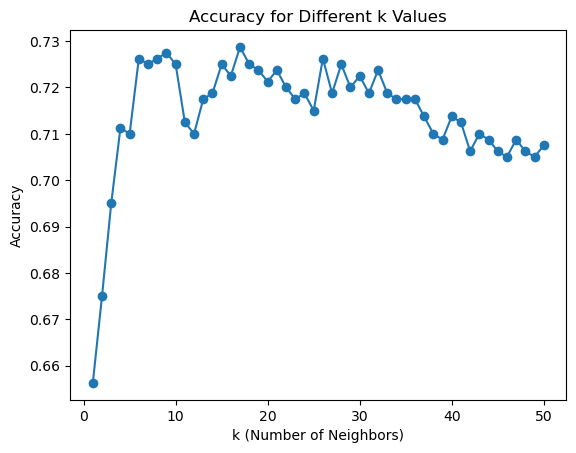

In [24]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier

# Define a range of k values to test
k_values = range(1, 51)  # Test k values from 1 to 50
accuracies = []

# Loop through different k values to find the best one
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)  # Train with the current k
    y_pred = knn.predict(X_test_scaled)  # Predict on the test set
    acc = accuracy_score(y_test, y_pred)  # Calculate accuracy
    accuracies.append(acc)  # Store the accuracy for each k

# Find the k with the highest accuracy
best_k = k_values[accuracies.index(max(accuracies))]
print(f"The best k value is: {best_k} with accuracy of {max(accuracies) * 100:.2f}%")

# Plot k vs accuracy

plt.plot(k_values, accuracies, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different k Values")
plt.show()

In [25]:
# 1. Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier

# 3. Initialize the k-NN classifier
k = best_k  # Choose the number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)

# 4. Perform k-fold cross-validation
cv_scores_distance_based = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation

# 5. Train the k-NN Classifier on the entire training set
knn.fit(X_train_scaled, y_train)

# 6. Make predictions on the test set
y_pred_distance_based = knn.predict(X_test_scaled)

## Model 4 Ensemble method - C


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

# Step 1: Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees in the forest

# Step 2: Fit the model (using the entire training set)
rf_model.fit(X_train, y_train)

# Step 3: Perform k-fold cross-validation (let's use k=10)
k = 10
cv_scores_random_forest = cross_val_score(rf_model, X_train, y_train, cv=k)

# Mean and standard deviation of accuracy
mean_accuracy = cv_scores_random_forest.mean()
std_accuracy = cv_scores_random_forest.std()

# Step 4: Generate predictions and evaluate the confusion matrix
y_pred = cross_val_predict(rf_model, X_train, y_train, cv=k)


# Test set performance
y_test_pred_random_forest = rf_model.predict(X_test)

## Discussion

Are all models equally well suited for this task? Discuss your conclusion.

Naive Bayes is not well suited, because there's a high feature correlation in the data set and this model is unable to capture them.

Decision Tree could work quite well, but pruning might not minimize overfitting enough.

K-Nearest-Neighbors might struggle with this large data set of 4000 sample data.

Random Forest should work the best, because it doesn't have the disadvantages that the other models suffer from.

# Evaluation

Evaluate the four models using k-fold cross validation and give at least accuracy (mean and standard deviation) and
confusion matrix for the trained models. Is one of the models significantly better than the others?

In [27]:
def plot_boxplot(scores, model_name="Model"):
    """
    Plots a box plot for cross-validation scores.
    
    Parameters:
    - scores (list or array): Cross-validation scores to visualize.
    - model_name (str): Name of the model (for labeling purposes).
    """
        
    print(f"Cross-validation scores: {scores}")
    print(f"Mean CV score: {scores.mean():.2f}")
    plt.boxplot(scores, vert=False, patch_artist=True)
    plt.title(f"Cross-Validation Scores ({model_name})")
    plt.xlabel("Score")
    plt.yticks([1], [model_name])
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels=None):
    """
    Plots a confusion matrix.
    
    Parameters:
    - y_true (array-like): Ground truth (correct) target values.
    - y_pred (array-like): Estimated targets as returned by a classifier.
    - labels (list, optional): Class labels to display on the axes.
    """
        
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    conf_matrix = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap="Blues", alpha=0.6)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', color="black")
    
    plt.title("Confusion Matrix")
    if labels:
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



## Model 1 probabilistic

Cross-validation scores: [0.678125  0.6703125 0.7015625 0.6765625 0.6578125]
Mean CV score: 0.68


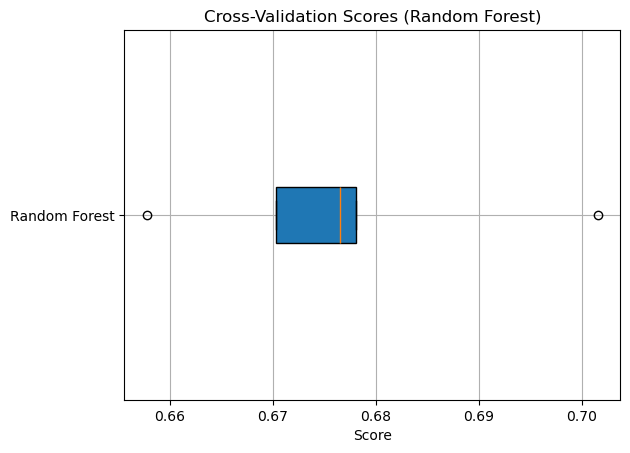

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       412
           1       0.30      0.17      0.22       136
           2       0.74      0.70      0.72       252

    accuracy                           0.68       800
   macro avg       0.59      0.57      0.57       800
weighted avg       0.65      0.68      0.66       800



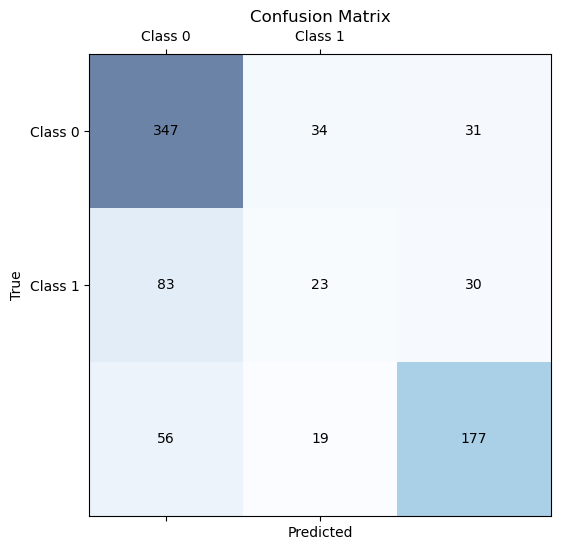

In [28]:
plot_boxplot(cv_scores_probabilistic, model_name="Random Forest")
plot_confusion_matrix(y_test, y_pred_probabilistic, labels=["Class 0", "Class 1"])


## Model 2 tree based - B

Cross-validation scores: [0.753125  0.734375  0.7578125 0.746875  0.7453125]
Mean CV score: 0.75


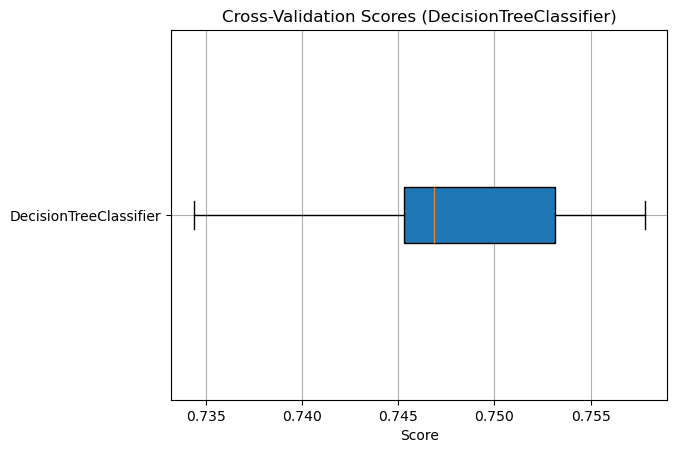

Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       412
           1       0.37      0.38      0.37       136
           2       0.71      0.70      0.70       252

    accuracy                           0.70       800
   macro avg       0.63      0.63      0.63       800
weighted avg       0.71      0.70      0.71       800



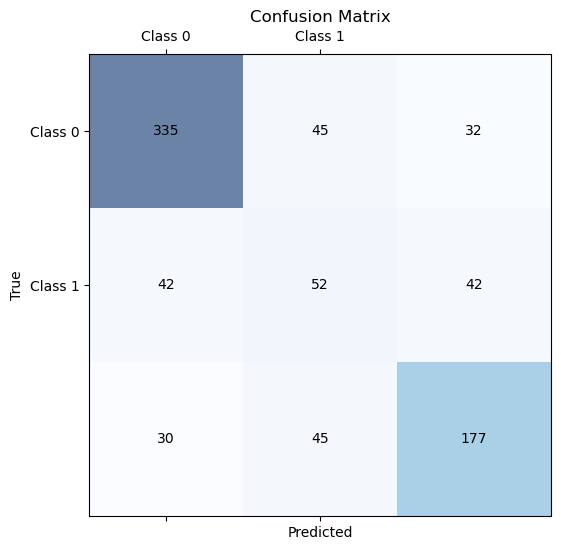

In [29]:
plot_boxplot(cv_scores_tree, model_name="DecisionTreeClassifier")
plot_confusion_matrix(y_test, y_pred_tree, labels=["Class 0", "Class 1"])

## Model 3 distance-based  - M

Cross-validation scores: [0.725     0.6921875 0.71875   0.6828125 0.6859375]
Mean CV score: 0.70


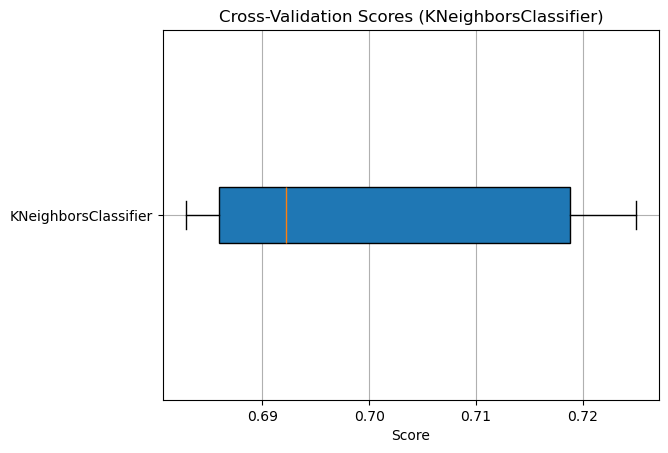

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       412
           1       0.55      0.18      0.27       136
           2       0.85      0.62      0.72       252

    accuracy                           0.73       800
   macro avg       0.70      0.59      0.60       800
weighted avg       0.72      0.73      0.69       800



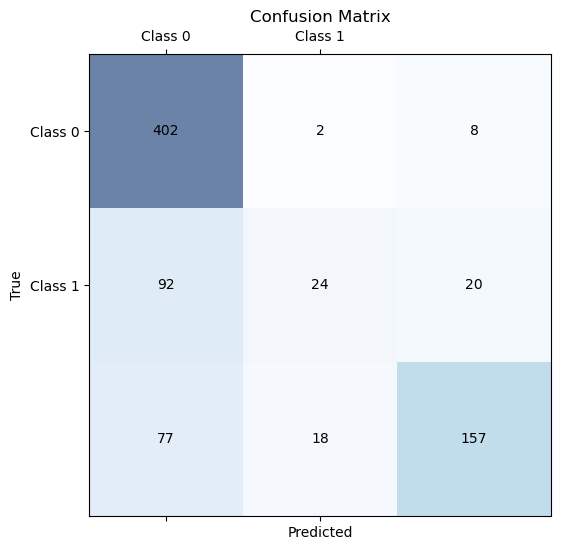

In [30]:
plot_boxplot(cv_scores_distance_based, model_name="KNeighborsClassifier")
plot_confusion_matrix(y_test, y_pred_distance_based, labels=["Class 0", "Class 1"])

## Model 4 Ensemble method - C

Cross-validation scores: [0.753125 0.790625 0.75     0.74375  0.765625 0.76875  0.803125 0.78125
 0.775    0.778125]
Mean CV score: 0.77


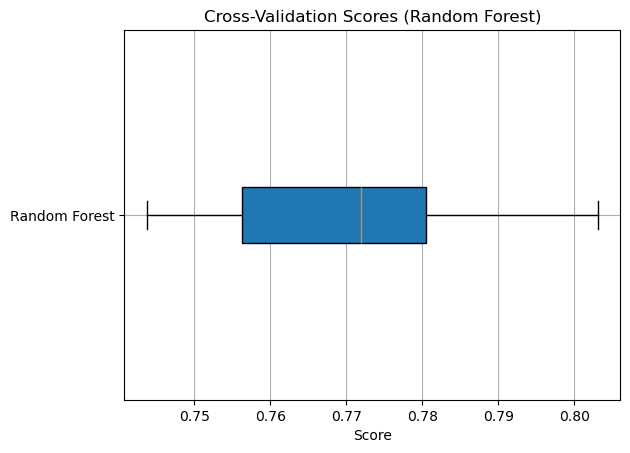

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       412
           1       0.63      0.35      0.45       136
           2       0.84      0.77      0.80       252

    accuracy                           0.79       800
   macro avg       0.75      0.69      0.71       800
weighted avg       0.78      0.79      0.78       800



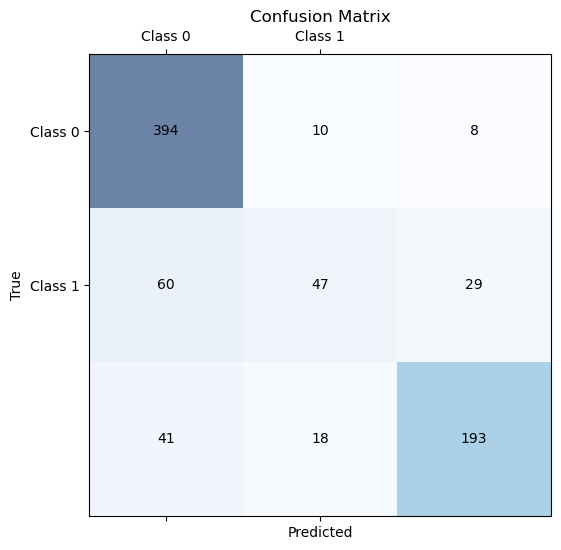

In [31]:
plot_boxplot(cv_scores_random_forest, model_name="Random Forest")
plot_confusion_matrix(y_test, y_test_pred_random_forest, labels=["Class 0", "Class 1"])

According to the confusion matrices, all the four models are very good at predicting which students are likely to graduate and also quite good at who's likely to drop out. However, they still have trouble to make predictions for class 1, so students who are at a moderate danger of dropping out. This is probably due to the fact that there's no clear line from when students should be put into class 0 or 2.

In conclusion, the random forest model (ensemble method) outperforms the other models in every single metric.

# Pick your favorite model. 
Which features were most relevant for the for the students’ success?


We pick the random forest (ensemble method) as our best model since, as already discussed, it did the best in our evaluation, in particular measured by the accuracy.

In [32]:
feature_importances = rf_model.feature_importances_

# Combine feature names and their importances into a single array
features_with_importances = np.array(list(zip(feature_names, feature_importances)))

# Sort by importance (descending order)
sorted_features = sorted(features_with_importances, key=lambda x: float(x[1]), reverse=True)

# Get the top 5 features
top_5_features = sorted_features[:5]

# Display the top 5 features
print("Top 5 Relevant Features:")
for feature, importance in top_5_features:
    print(f"{feature}: {importance}")

Top 5 Relevant Features:
Curricular units 2nd sem (approved): 0.1377799941082098
Curricular units 2nd sem (grade): 0.1104730149957986
Curricular units 1st sem (approved): 0.08832329761949008
Curricular units 1st sem (grade): 0.06733771142460211
Admission grade: 0.04158243884310831


With its built-in feature importance we learn that the following features are the most relevant for the students' success: Curricular units 2nd sem (approved), Curricular units 2nd sem (grade), Curricular units 1st sem (approved), Curricular units 1st sem (grade) and Admission grade.



# Save your favorite model as pickle-file with https://scikit-learn.org/stable/model_persistence.html. Call the file “best_model.pkl”.


The submission consists of two files:
1. A Jupyter Notebook containing the preprocessing, the training, and the evaluation of
your models.
2. A pickle-file “best_model.pkl”

In [33]:
import pickle

# Save the model to a pickle file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)